## RAVDESS + TESS model training:

#### General setup:

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
!pip install datasets --quiet

In [4]:
# Base Libraries
import os
import gc
import time
import shutil
import random
# import librosa

import torch
import numpy as np
import pandas as pd
import seaborn as sns
# import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt
from collections import defaultdict

# Preprocessing and Image
# import cv2
import librosa.display

from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# from keras.utils import image_dataset_from_directory
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

In [5]:
def plot_emotion_distribution(train_df, val_df, test_df):
  datasets = [train_df, test_df, val_df]
  dataset_names = ['Train', 'Test', 'Validation']
  emotion_counts = []

  for dataset in datasets:
    emotion_percent = dataset['emotion'].value_counts(normalize=True) * 100
    emotion_counts.append(emotion_percent.sort_index())

  fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
  for i, (counts, name) in enumerate(zip(emotion_counts, dataset_names)):
    sns.barplot(x=counts.index, y=counts.values, palette="viridis", ax=axes[i])
    axes[i].set_title(f'{name} Dataset')
    axes[i].set_xlabel('Emotion')
    axes[i].set_ylabel('Percentage' if i == 0 else '')
    axes[i].tick_params(axis='x', rotation=45)

  plt.suptitle('Percentage of Emotions in Train, Test, and Validation Datasets')
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

In [48]:
label_to_emotion = {
  0: "neutral",
  1: "happy",
  2: "sad",
  3: "angry",
  4: "fearful",
  5: "disgust",
  6: "surprised"
}

In [49]:
def plot_emotion_label_distribution(train_df, val_df, test_df):
  datasets = [train_df, test_df, val_df]
  dataset_names = ['Train', 'Test', 'Validation']
  emotion_counts = []

  for dataset in datasets:
      emotion_percent = dataset['emotion_label'].value_counts(normalize=True) * 100
      emotion_percent = emotion_percent.sort_index()
      emotion_percent.index = emotion_percent.index.map(label_to_emotion)
      emotion_counts.append(emotion_percent)

  fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
  for i, (counts, name) in enumerate(zip(emotion_counts, dataset_names)):
      sns.barplot(x=counts.index, y=counts.values, palette="viridis", ax=axes[i])
      axes[i].set_title(f'{name} Dataset')
      axes[i].set_xlabel('Emotion')
      axes[i].set_ylabel('Percentage' if i == 0 else '')
      axes[i].tick_params(axis='x', rotation=45)

  plt.suptitle('Percentage of Emotions in Train, Test, and Validation Datasets')
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

#### Data loading and preprocessing:

##### RAVDESS data loading:

In [8]:
# Assign the Kaggle data set URL into variable
ravdess_dataset = 'https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data'
# Using opendatasets let's download the data sets
od.download(ravdess_dataset, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: khrystynadolynska
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio


100%|██████████| 429M/429M [00:00<00:00, 523MB/s]


In [9]:
ravdess_data_dir = './ravdess-emotional-speech-audio'
ravdess_content_list = os.listdir(ravdess_data_dir)
ravdess_content_list

['Actor_10',
 'Actor_19',
 'Actor_08',
 'Actor_17',
 'Actor_22',
 'Actor_11',
 'Actor_15',
 'Actor_07',
 'Actor_04',
 'Actor_12',
 'Actor_03',
 'Actor_21',
 'Actor_06',
 'Actor_16',
 'Actor_01',
 'Actor_02',
 'Actor_23',
 'Actor_24',
 'Actor_18',
 'Actor_20',
 'Actor_13',
 'Actor_14',
 'Actor_09',
 'audio_speech_actors_01-24',
 'Actor_05']

In [10]:
ravdess_content_list.remove('audio_speech_actors_01-24')
# content_list

In [11]:
ravdess_label_to_char = {
    'modality': {
        1: "full-AV",
        2: "video-only",
        3: "audio-only"
    },
    'vocal_channel': {
        1: "speech",
        2: "song"
    },
    'emotion': {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fearful",
        7: "disgust",
        8: "surprised"
    },
    'emotional_intensity': {
        1: "normal",
        2: "strong"
    },
    'statement': {
        1: "Kids are talking by the door",
        2: "Dogs are sitting by the door"
    },
    'repetition': {
        1: "1st repetition",
        2: "2nd repetition"
    },
    # 'Actor': parts[6],
    'gender': {
        1: "Male",
        2: "Female"
    }
}

ravdess_char_to_label = {
    'modality': {
        "full-AV": 1,
        "video-only": 2,
        "audio-only": 3
    },
    'vocal_channel': {
        "speech": 1,
        "song": 2
    },
    'emotion': {
        "neutral": 1,
        "calm": 2,
        "happy": 3,
        "sad": 4,
        "angry": 5,
        "fearful": 6,
        "disgust": 7,
        "surprised": 8
    },
    'emotional_intensity': {
        "normal": 1,
        "strong": 2
    },
    'statement': {
        "Kids are talking by the door": 1,
        "Dogs are sitting by the door": 2
    },
    'repetition': {
        "1st repetition": 1,
        "2nd repetition": 2
    },
    # 'Actor': parts[6],
    'gender': {
        "Male": 1,
        "Female": 2
    }
}

ravdess_label_convert = {
    'LABEL_0': "neutral",
    'LABEL_1': "calm",
    'LABEL_2': "happy",
    'LABEL_3': "sad",
    'LABEL_4': "angry",
    'LABEL_5': "fearful",
    'LABEL_6': "disgust",
    'LABEL_7': "surprised"
}

In [12]:
# !rm -r ./ravdess_train_dataset
# !rm -r ./ravdess_val_dataset
# !rm -r ./ravdess_test_dataset

##### RAVDESS data preprocessing:

In [13]:
ravdess_data_dir = './ravdess-emotional-speech-audio'
ravdess_train_dir = './ravdess_train_dataset'
ravdess_val_dir = './ravdess_val_dataset'
ravdess_test_dir = './ravdess_test_dataset'

os.makedirs(ravdess_train_dir, exist_ok=True)
os.makedirs(ravdess_val_dir, exist_ok=True)
os.makedirs(ravdess_test_dir, exist_ok=True)

In [14]:
ravdess_content_list = [folder for folder in os.listdir(ravdess_data_dir) if os.path.isdir(os.path.join(ravdess_data_dir, folder))]
ravdess_content_list.remove('audio_speech_actors_01-24')
ravdess_content_list

['Actor_10',
 'Actor_19',
 'Actor_08',
 'Actor_17',
 'Actor_22',
 'Actor_11',
 'Actor_15',
 'Actor_07',
 'Actor_04',
 'Actor_12',
 'Actor_03',
 'Actor_21',
 'Actor_06',
 'Actor_16',
 'Actor_01',
 'Actor_02',
 'Actor_23',
 'Actor_24',
 'Actor_18',
 'Actor_20',
 'Actor_13',
 'Actor_14',
 'Actor_09',
 'Actor_05']

In [15]:
test_samples = 1
val_samples = 1
train_samples = 11

train_male = train_female = 0
val_male = val_female = 0
test_male = test_female = 0

train_actors, val_actors, test_actors = [], [], []
random.shuffle(ravdess_content_list)

for item in ravdess_content_list:
  name_items = item.split('_')
  actor_id = int(name_items[1])

  if actor_id % 2 == 0:  # female
    if test_female < test_samples:
      test_actors.append(item)
      test_female += 1
    elif val_female < val_samples:
      val_actors.append(item)
      val_female += 1
    elif train_female < train_samples:
      train_actors.append(item)
      train_female += 1
  else:  # male
    if test_male < test_samples:
      test_actors.append(item)
      test_male += 1
    elif val_male < val_samples:
      val_actors.append(item)
      val_male += 1
    elif train_male < train_samples:
      train_actors.append(item)
      train_male += 1

print(f"Train actors ({len(train_actors)}): {train_actors}")
print(f"Validation actors ({len(val_actors)}): {val_actors}")
print(f"Test actors ({len(test_actors)}): {test_actors}")

Train actors (20): ['Actor_08', 'Actor_05', 'Actor_22', 'Actor_06', 'Actor_09', 'Actor_18', 'Actor_12', 'Actor_21', 'Actor_14', 'Actor_01', 'Actor_20', 'Actor_24', 'Actor_13', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_23', 'Actor_07', 'Actor_15', 'Actor_19']
Validation actors (2): ['Actor_10', 'Actor_17']
Test actors (2): ['Actor_11', 'Actor_16']


In [16]:
def copy_directory(src, dst):
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)

for actor_folder in ravdess_content_list:
  source_path = os.path.join(ravdess_data_dir, actor_folder)
  if actor_folder in test_actors:
    destination_path = os.path.join(ravdess_test_dir, actor_folder)
  elif actor_folder in val_actors:
    destination_path = os.path.join(ravdess_val_dir, actor_folder)
  elif actor_folder in train_actors:
    destination_path = os.path.join(ravdess_train_dir, actor_folder)
  else:
    continue
  copy_directory(source_path, destination_path)

In [17]:
def extract_labels(filename):
  parts = os.path.splitext(filename)[0].split('-')
  return {
    'modality': ravdess_char_to_label['modality'][parts[0]],
    'vocal_channel': ravdess_char_to_label['vocal_channel'][parts[1]],
    'emotion': ravdess_char_to_label['emotion'][parts[2]],
    'emotional_intensity': ravdess_char_to_label['emotional_intensity'][parts[3]],
    'statement': ravdess_char_to_label['statement'][parts[4]],
    'repetition': ravdess_char_to_label['repetition'][parts[5]],
    'actor': int(parts[6]),
    'gender': ravdess_char_to_label['gender'][2] if int(parts[6]) % 2 == 0 else ravdess_char_to_label['gender'][1]
  }

def extract_chars(filename):
  parts = os.path.splitext(filename)[0].split('-')
  int_parts = [int(part) for part in parts]
  return {
    'modality': ravdess_label_to_char['modality'][int_parts[0]],
    'vocal_channel': ravdess_label_to_char['vocal_channel'][int_parts[1]],
    'emotion': ravdess_label_to_char['emotion'][int_parts[2]],
    'emotional_intensity': ravdess_label_to_char['emotional_intensity'][int_parts[3]],
    'statement': ravdess_label_to_char['statement'][int_parts[4]],
    'repetition': ravdess_label_to_char['repetition'][int_parts[5]],
    'actor': int_parts[6],
    'gender': ravdess_label_to_char['gender'][2] if int_parts[6] % 2 == 0 else ravdess_label_to_char['gender'][1]
  }

def create_ravdess_df(data_dir):
  audio_files = []
  metadata = []

  for root, _, files in os.walk(data_dir):
    for file in files:
      if file.endswith(".wav"):
        audio_files.append(os.path.join(root, file))
        metadata.append(extract_chars(file))

  df = pd.DataFrame(metadata)
  df.columns = df.columns.map(str).str.lower()

  for col in ['modality', 'vocal_channel', 'emotion',
              'emotional_intensity', 'statement', 'repetition', 'gender']:
    df[col] = df[col].astype(str)

  df['actor'] = df['actor'].astype(int)
  # df['emotion_label'] = df['emotion'].map(ravdess_char_to_label['emotion'])
  df['emotion_label'] = df['emotion'].map(ravdess_char_to_label['emotion'])
  df.insert(0, 'file_path', audio_files)
  return df

In [18]:
ravdess_train_df = create_ravdess_df(ravdess_train_dir)
ravdess_val_df = create_ravdess_df(ravdess_val_dir)
ravdess_test_df = create_ravdess_df(ravdess_test_dir)

In [19]:
print("Train dataset:")
ravdess_train_df.head()

Train dataset:


,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,gender,emotion_label
0,./ravdess_train_dataset/Actor_19/03-01-04-02-0...,audio-only,speech,sad,strong,Kids are talking by the door,2nd repetition,19,Male,4
1,./ravdess_train_dataset/Actor_19/03-01-01-01-0...,audio-only,speech,neutral,normal,Kids are talking by the door,2nd repetition,19,Male,1
2,./ravdess_train_dataset/Actor_19/03-01-04-02-0...,audio-only,speech,sad,strong,Kids are talking by the door,1st repetition,19,Male,4
3,./ravdess_train_dataset/Actor_19/03-01-05-01-0...,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,19,Male,5
4,./ravdess_train_dataset/Actor_19/03-01-02-01-0...,audio-only,speech,calm,normal,Dogs are sitting by the door,1st repetition,19,Male,2


In [22]:
def remove_calm_and_remap(df):
  df = df[df['emotion'] != 'calm'].copy()

  old_labels = sorted(df['emotion_label'].unique())
  new_label_map = {old: new for new, old in enumerate(old_labels)}

  df['emotion_label'] = df['emotion_label'].map(new_label_map)

  return df

In [23]:
ravdess_train_df = remove_calm_and_remap(ravdess_train_df)
ravdess_val_df = remove_calm_and_remap(ravdess_val_df)
ravdess_test_df = remove_calm_and_remap(ravdess_test_df)

In [24]:
print("Train dataset:")
ravdess_train_df.head()

Train dataset:


,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,gender,emotion_label
0,./ravdess_train_dataset/Actor_19/03-01-04-02-0...,audio-only,speech,sad,strong,Kids are talking by the door,2nd repetition,19,Male,2
1,./ravdess_train_dataset/Actor_19/03-01-01-01-0...,audio-only,speech,neutral,normal,Kids are talking by the door,2nd repetition,19,Male,0
2,./ravdess_train_dataset/Actor_19/03-01-04-02-0...,audio-only,speech,sad,strong,Kids are talking by the door,1st repetition,19,Male,2
3,./ravdess_train_dataset/Actor_19/03-01-05-01-0...,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,19,Male,3
5,./ravdess_train_dataset/Actor_19/03-01-05-01-0...,audio-only,speech,angry,normal,Dogs are sitting by the door,1st repetition,19,Male,3


In [25]:
ravdess_train_df["emotion"].value_counts()

,count
emotion,
sad,160
angry,160
fearful,160
disgust,160
surprised,160
happy,160
neutral,80


In [26]:
ravdess_train_df["emotion_label"].value_counts()

,count
emotion_label,
2,160
3,160
4,160
5,160
6,160
1,160
0,80


##### RAVDESS dataset analysis:

In [ ]:
# datasets = [ravdess_train_df, ravdess_test_df, ravdess_val_df]
# dataset_names = ['Train', 'Test', 'Validation']
# emotion_counts = []
# for dataset in datasets:
#   emotion_counts_i = dataset['emotion'].value_counts(normalize=True) * 100
#   emotion_counts.append(emotion_counts_i.sort_index())

# fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
# for i, (counts, name) in enumerate(zip(emotion_counts, dataset_names)):
#     sns.barplot(x=counts.index, y=counts.values, palette="viridis", ax=axes[i])
#     axes[i].set_title(f'{name} Dataset')
#     axes[i].set_xlabel('Emotion')
#     axes[i].set_ylabel('Percentage' if i == 0 else '')
#     axes[i].tick_params(axis='x', rotation=45)

# plt.suptitle('Percentage of Emotions in Train, Test, and Validation Datasets')
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()

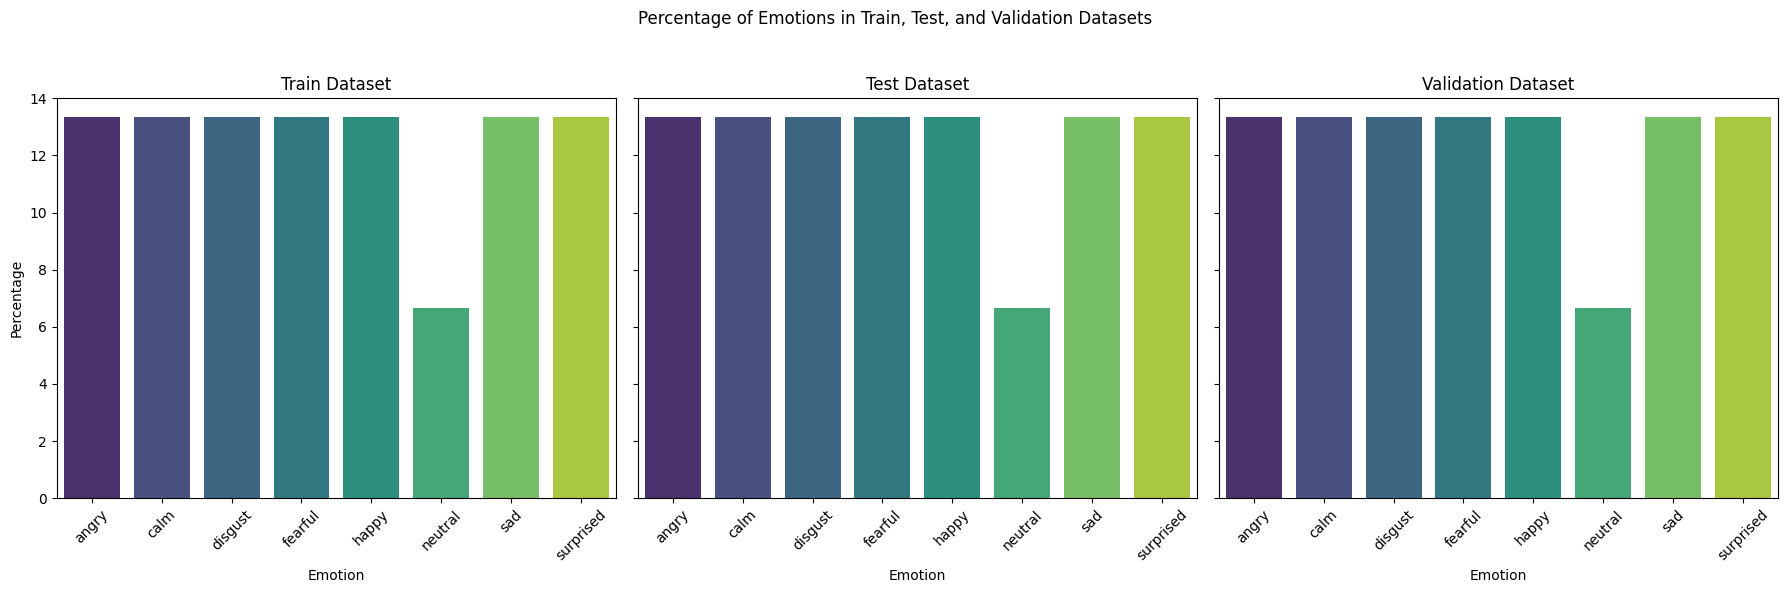

In [ ]:
plot_emotion_distribution(ravdess_train_df, ravdess_val_df, ravdess_test_df)

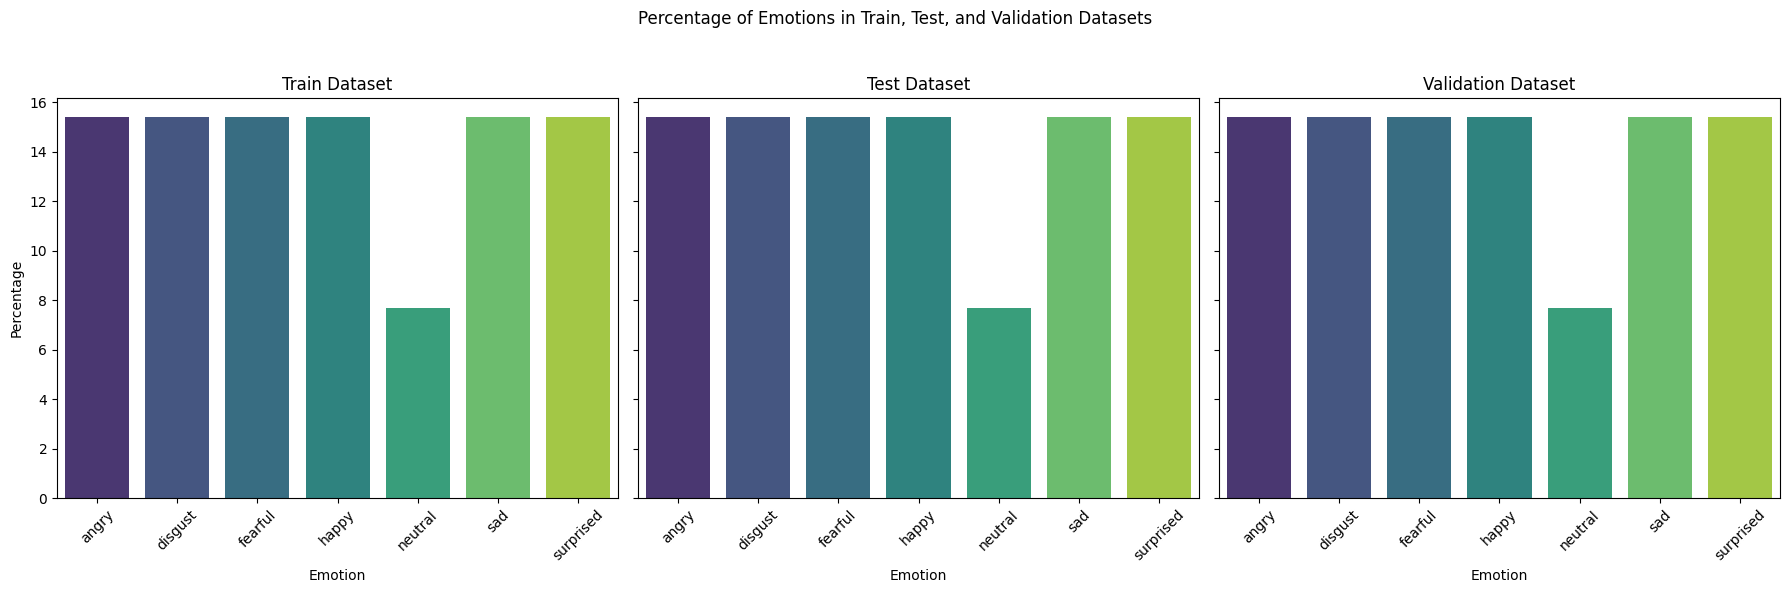

In [27]:
plot_emotion_distribution(ravdess_train_df, ravdess_val_df, ravdess_test_df)

##### TESS data loading:

In [28]:
# Assign the Kaggle data set URL into variable
tess_dataset = 'https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess/data'
# Using opendatasets let's download the data sets
od.download(tess_dataset, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: khrystynadolynska
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess


100%|██████████| 428M/428M [00:00<00:00, 456MB/s]


In [29]:
dir1 = "/content/toronto-emotional-speech-set-tess/tess toronto emotional speech set data"
dir2 = "/content/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data"

def count_wav_files(directory):
  count = 0
  for root, _, files in os.walk(directory):
    count += len([file for file in files if file.endswith(".wav")])
  return count

count_dir1 = count_wav_files(dir1)
count_dir2 = count_wav_files(dir2)

print(f".wav files in dir1: {count_dir1}")
print(f".wav files in dir2: {count_dir2}")

.wav files in dir1: 2800
.wav files in dir2: 2800


In [30]:
tess_data_dir = './toronto-emotional-speech-set-tess'
tess_content_list = os.listdir(tess_data_dir)
tess_content_list

['TESS Toronto emotional speech set data',
 'tess toronto emotional speech set data']

In [31]:
tess_emotion_map = {
  "neutral": 0,
  "happy": 1,
  "sad": 2,
  "angry": 3,
  "fear": 4,
  "fearful": 4,
  "disgust": 5,
  "pleasant_surprise": 6,
  "pleasant_surprised": 6,
  "surprised": 6
}

In [32]:
# !rm -r ./tess_train_dataset
# !rm -r ./tess_val_dataset
# !rm -r ./tess_test_dataset

##### TESS data preprocessing:

In [33]:
base_dir = "/content/toronto-emotional-speech-set-tess"
dup_dir = os.path.join(base_dir, "tess toronto emotional speech set data")
main_dir = os.path.join(base_dir, "TESS Toronto emotional speech set data")

if os.path.exists(dup_dir):
  shutil.rmtree(dup_dir)
  print("Duplicate directory removed.")

Duplicate directory removed.


In [34]:
os.listdir(tess_data_dir)

['TESS Toronto emotional speech set data']

In [35]:
tess_train_dir = './tess_train_dataset'
tess_val_dir = './tess_val_dataset'
tess_test_dir = './tess_test_dataset'

os.makedirs(tess_train_dir, exist_ok=True)
os.makedirs(tess_val_dir, exist_ok=True)
os.makedirs(tess_test_dir, exist_ok=True)

In [36]:
word_to_files = defaultdict(list)
for root, _, files in os.walk(main_dir):
  for file in files:
    if file.endswith(".wav"):
      parts = file.split('_')
      if len(parts) != 3:
        print(f"File name: {parts}")
        continue
      word = parts[1]
      word_to_files[word].append(os.path.join(root, file))

In [37]:
all_words = list(word_to_files.keys())
random.shuffle(all_words)

val_words = all_words[:20]
test_words = all_words[20:40]
train_words = all_words[40:]

print("Validation words:", val_words)
print("Test words:", test_words)
print(f"Train words (5 out of {len(train_words)}): {train_words[:5]}")

Validation words: ['time', 'nice', 'bean', 'rose', 'rag', 'youth', 'shall', 'lot', 'size', 'peg', 'ripe', 'sure', 'lore', 'soup', 'have', 'hit', 'came', 'join', 'talk', 'sub']
Test words: ['near', 'hash', 'void', 'gun', 'mob', 'dip', 'love', 'shirt', 'king', 'south', 'choice', 'witch', 'death', 'mess', 'fit', 'raise', 'calm', 'tool', 'chat', 'wash']
Train words (5 out of 160): ['jail', 'tell', 'rough', 'met', 'lease']


In [38]:
train_set = set(train_words)
val_set = set(val_words)
test_set = set(test_words)

val_in_train = val_set & train_set
test_in_train = test_set & train_set

if val_in_train:
  print(f"Validation words in train: {val_in_train}")
else:
  print("No validation words in training set.")

if test_in_train:
  print(f"Test words in train: {test_in_train}")
else:
  print("No test words in training set.")

No validation words in training set.
No test words in training set.


In [39]:
def copy_files(word_list, dst_dir):
  for word in word_list:
    for file_path in word_to_files[word]:
      label = file_path.split('/')[-2]
      dst_label_dir = os.path.join(dst_dir, label)
      os.makedirs(dst_label_dir, exist_ok=True)
      shutil.copy(file_path, os.path.join(dst_label_dir, os.path.basename(file_path)))

copy_files(train_words, tess_train_dir)
copy_files(val_words, tess_val_dir)
copy_files(test_words, tess_test_dir)

In [40]:
def count_wavs(dir_path):
  return sum(len([f for f in files if f.endswith(".wav")]) for _, _, files in os.walk(dir_path))

print("Train .wav files:", count_wavs(tess_train_dir))
print("Val .wav files:", count_wavs(tess_val_dir))
print("Test .wav files:", count_wavs(tess_test_dir))

Train .wav files: 2240
Val .wav files: 280
Test .wav files: 280


In [41]:
def create_tess_df(data_dir):
  records = []
  for root, _, files in os.walk(data_dir):
    for f in files:
      if f.endswith(".wav"):
        path = os.path.join(root, f)
        parts = f.split('_')
        if len(parts) != 3:
          continue
        word = parts[1]
        raw_emotion = parts[2].replace(".wav", "").lower()
        emotion = raw_emotion.replace("fearful", "fear")
        emotion = raw_emotion.replace("ps", "surprised")
        label = tess_emotion_map.get(emotion)
        if label is not None:
          records.append({
            "file_path": path,
            "word": word,
            "emotion": emotion,
            "emotion_label": label
          })
  return pd.DataFrame(records)

In [42]:
tess_train_df = create_tess_df(tess_train_dir)
tess_val_df = create_tess_df(tess_val_dir)
tess_test_df = create_tess_df(tess_test_dir)

print("Train samples:", len(tess_train_df))
print("Validation samples:", len(tess_val_df))
print("Test samples:", len(tess_test_df))

Train samples: 2240
Validation samples: 280
Test samples: 280


In [43]:
tess_train_df.head()

,file_path,word,emotion,emotion_label
0,./tess_train_dataset/OAF_angry/OAF_chalk_angry...,chalk,angry,3
1,./tess_train_dataset/OAF_angry/OAF_hush_angry.wav,hush,angry,3
2,./tess_train_dataset/OAF_angry/OAF_germ_angry.wav,germ,angry,3
3,./tess_train_dataset/OAF_angry/OAF_ditch_angry...,ditch,angry,3
4,./tess_train_dataset/OAF_angry/OAF_rush_angry.wav,rush,angry,3


##### TESS dataset analysis:

In [44]:
def print_counts(df, name):
  print(f"--- {name} Dataset ---")
  print("Emotion counts:")
  print(df['emotion'].value_counts())
  print("\nWord counts:")
  print(df['word'].value_counts())
  print()

print_counts(tess_train_df, "Train")
print_counts(tess_val_df, "Validation")
print_counts(tess_test_df, "Test")

--- Train Dataset ---
Emotion counts:
emotion
angry        320
disgust      320
sad          320
neutral      320
fear         320
surprised    320
happy        320
Name: count, dtype: int64

Word counts:
word
chalk    14
hush     14
germ     14
ditch    14
rush     14
         ..
juice    14
moon     14
hire     14
nag      14
pearl    14
Name: count, Length: 160, dtype: int64

--- Validation Dataset ---
Emotion counts:
emotion
angry        40
disgust      40
sad          40
neutral      40
fear         40
surprised    40
happy        40
Name: count, dtype: int64

Word counts:
word
lore     14
rose     14
youth    14
sub      14
join     14
shall    14
soup     14
peg      14
talk     14
bean     14
hit      14
lot      14
time     14
came     14
rag      14
sure     14
size     14
ripe     14
nice     14
have     14
Name: count, dtype: int64

--- Test Dataset ---
Emotion counts:
emotion
angry        40
disgust      40
sad          40
neutral      40
fear         40
surprised    40
ha

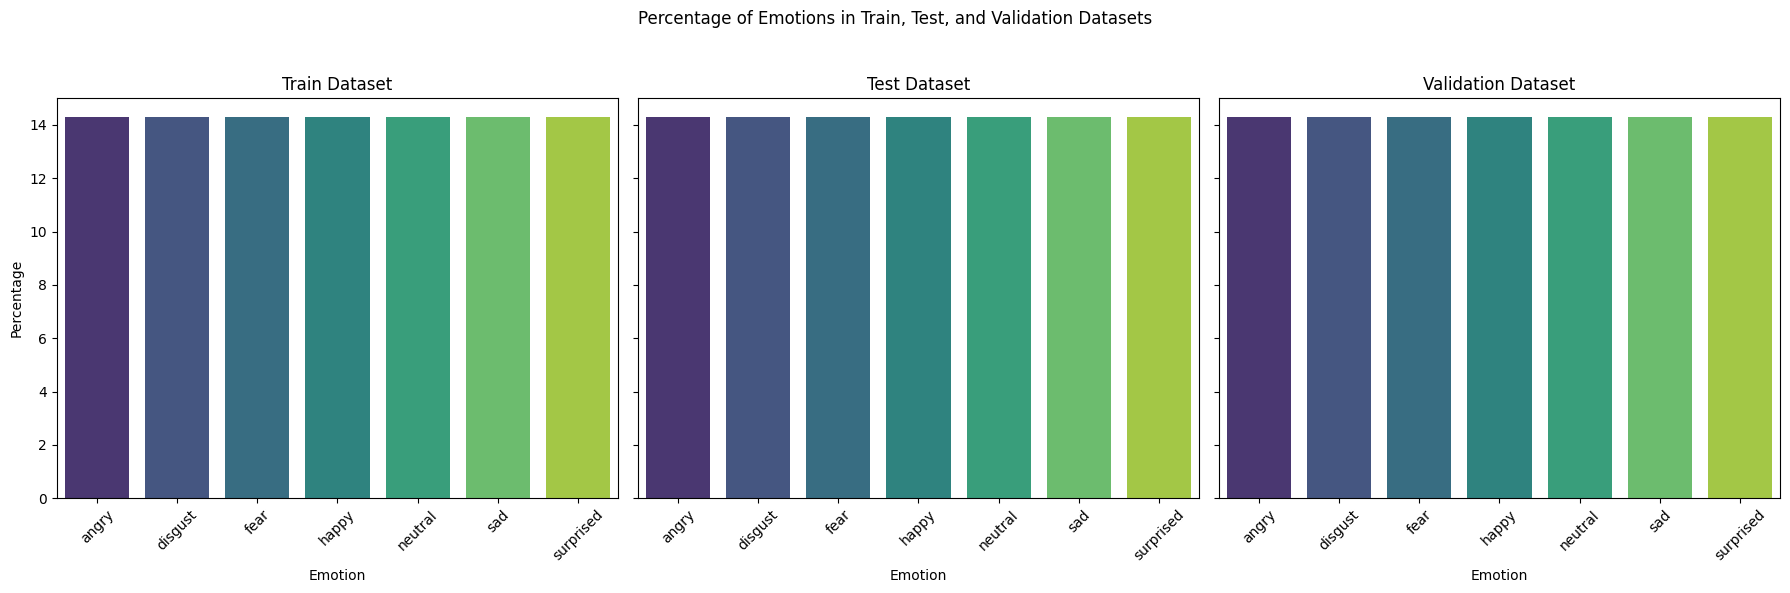

In [ ]:
plot_emotion_distribution(tess_train_df, tess_val_df, tess_test_df)

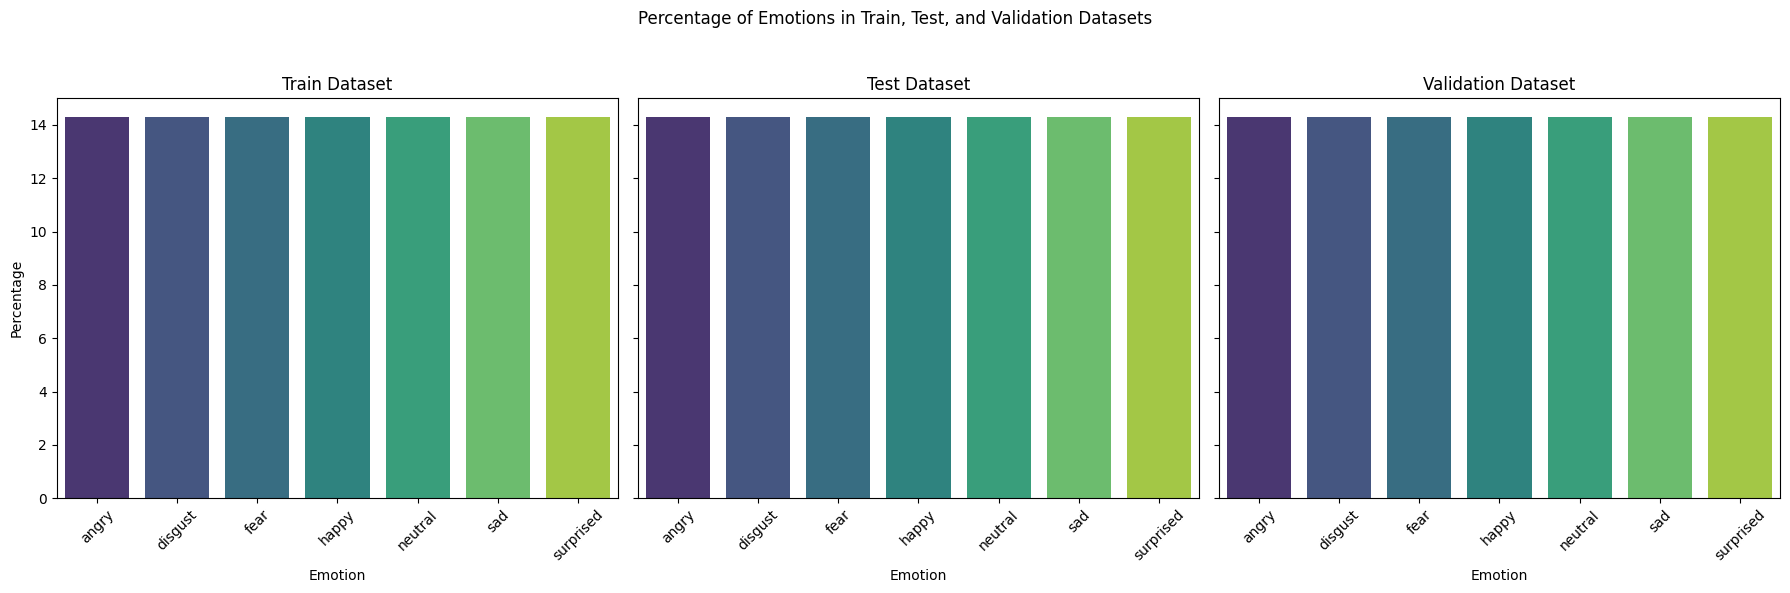

In [45]:
plot_emotion_distribution(tess_train_df, tess_val_df, tess_test_df)

#### Data aggregation:

In [46]:
ravdess_train_df = ravdess_train_df[['file_path', 'emotion_label']]
ravdess_val_df = ravdess_val_df[['file_path', 'emotion_label']]
ravdess_test_df = ravdess_test_df[['file_path', 'emotion_label']]

tess_train_df = tess_train_df[['file_path', 'emotion_label']]
tess_val_df = tess_val_df[['file_path', 'emotion_label']]
tess_test_df = tess_test_df[['file_path', 'emotion_label']]

train_df = pd.concat([ravdess_train_df, tess_train_df], ignore_index=True)
val_df = pd.concat([ravdess_val_df, tess_val_df], ignore_index=True)
test_df = pd.concat([ravdess_test_df, tess_test_df], ignore_index=True)

print("Train dataset size:", train_df.shape)
print("Validation dataset size:", val_df.shape)
print("Test dataset size:", test_df.shape)

Train dataset size: (3280, 2)
Validation dataset size: (384, 2)
Test dataset size: (384, 2)


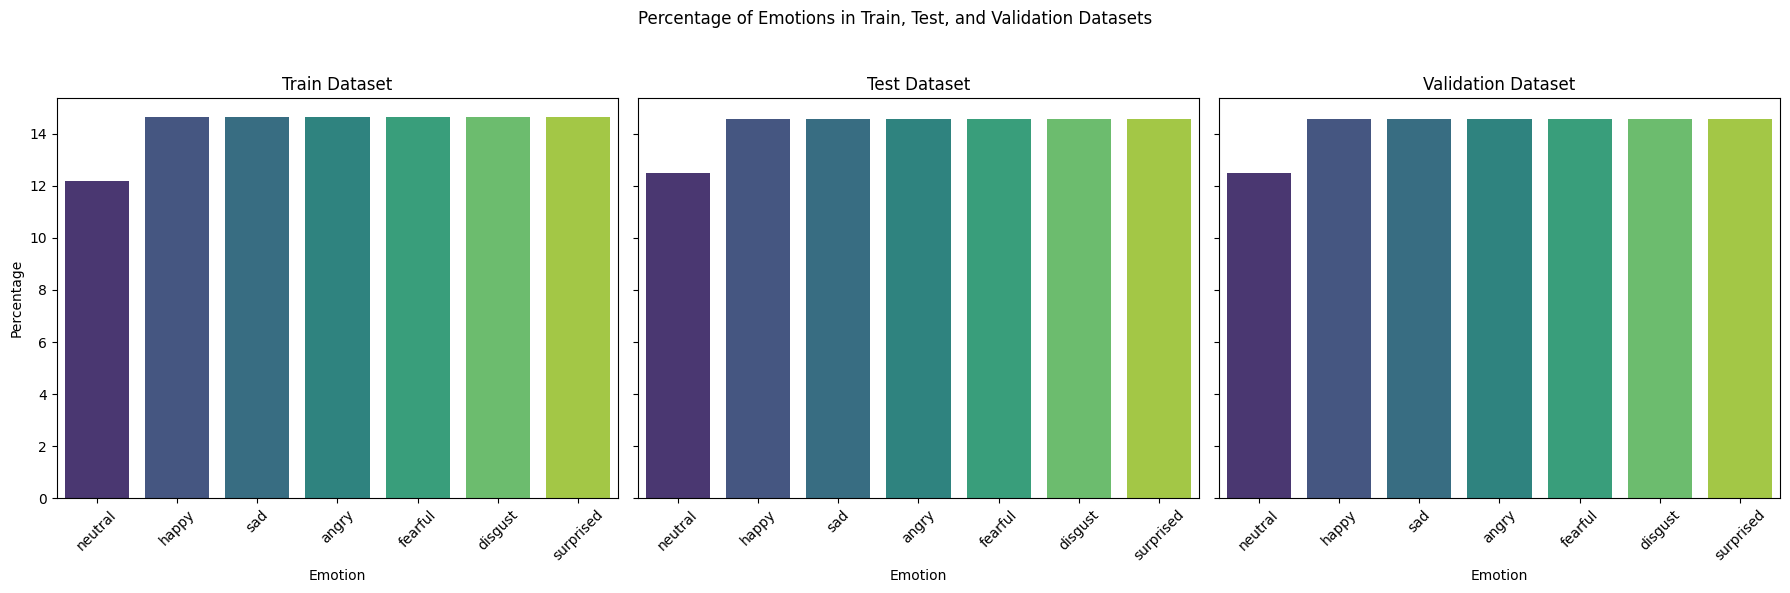

In [50]:
plot_emotion_label_distribution(train_df, val_df, test_df)

In [ ]:
train_df["emotion_label"] = train_df["emotion_label"] - 1
val_df["emotion_label"] = val_df["emotion_label"] - 1
test_df["emotion_label"] = test_df["emotion_label"] - 1

In [51]:
train_df.head()

,file_path,emotion_label
0,./ravdess_train_dataset/Actor_19/03-01-04-02-0...,2
1,./ravdess_train_dataset/Actor_19/03-01-01-01-0...,0
2,./ravdess_train_dataset/Actor_19/03-01-04-02-0...,2
3,./ravdess_train_dataset/Actor_19/03-01-05-01-0...,3
4,./ravdess_train_dataset/Actor_19/03-01-05-01-0...,3


In [52]:
train_df["emotion_label"].value_counts()

,count
emotion_label,
2,480
3,480
4,480
5,480
6,480
1,480
0,400


### Model training:

#### All emotions training:

##### Model setup & training:

In [53]:
import librosa
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import Wav2Vec2FeatureExtractor

In [54]:
def map_to_array(example):
  speech, _ = librosa.load(example["file_path"], sr=16000, mono=True)
  example["speech"] = speech
  return example

In [55]:
train_data = Dataset.from_pandas(train_df).map(map_to_array)
val_data = Dataset.from_pandas(val_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

Map:   0%|          | 0/3280 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

In [56]:
del train_df, test_df, val_df
gc.collect()

43

In [57]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er", num_labels=7)  #, ignore_mismatched_sizes=True)  # , num_labels=num_labels)

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [58]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [59]:
os.makedirs("./batches", exist_ok=True)

In [60]:
def save_batched_encodings(data, labels, feature_extractor, batch_size, prefix, output_dir):
  os.makedirs(output_dir, exist_ok=True)
  total = len(data)

  for i in tqdm(range(0, total, batch_size), desc=f"Encoding {prefix}"):
    batch_data = data[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    encodings = feature_extractor(batch_data, sampling_rate=16000, padding=True, return_tensors="pt")
    torch.save((encodings, batch_labels), os.path.join(output_dir, f"{prefix}_batch_{i//batch_size}.pt"))

    del encodings, batch_data, batch_labels
    gc.collect()

In [61]:
save_batched_encodings(list(train_data["speech"]), list(train_data["emotion_label"]), feature_extractor, batch_size=256, prefix="train", output_dir="./batches")
save_batched_encodings(list(val_data["speech"]), list(val_data["emotion_label"]), feature_extractor, batch_size=256, prefix="val", output_dir="./batches")
save_batched_encodings(list(test_data["speech"]), list(test_data["emotion_label"]), feature_extractor, batch_size=256, prefix="test", output_dir="./batches")

Encoding test: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


In [62]:
import torch
from torch.utils.data import Dataset

class BatchedDataset(Dataset):
  def __init__(self, batch_files):
    self.batch_files = batch_files
    self.samples = []

    for batch_idx, file in enumerate(batch_files):
      encodings, labels = torch.load(file, weights_only=False)
      n = len(labels)
      self.samples.extend([(batch_idx, i) for i in range(n)])

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    batch_idx, sample_idx = self.samples[idx]
    batch_file = self.batch_files[batch_idx]

    # Load full batch — must disable weights_only
    encodings, labels = torch.load(batch_file, weights_only=False)

    item = {key: val[sample_idx] for key, val in encodings.items()}
    item["emotion_label"] = torch.tensor(labels[sample_idx])
    return item

In [63]:
from glob import glob

train_files = sorted(glob("./batches/train_batch_*.pt"))
val_files = sorted(glob("./batches/val_batch_*.pt"))
test_files = sorted(glob("./batches/test_batch_*.pt"))

train_dataset = BatchedDataset(train_files)
val_dataset = BatchedDataset(val_files)
test_dataset = BatchedDataset(test_files)

In [64]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_values = [item["input_values"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = torch.tensor([item["emotion_label"] for item in batch])

    input_values_padded = pad_sequence(input_values, batch_first=True)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True)

    return {
        "input_values": input_values_padded,
        "attention_mask": attention_mask_padded,
        "emotion_label": labels
    }

In [67]:
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [69]:
# del train_loader, test_loader, val_loader
# gc.collect()

In [68]:
num_labels=7
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [106]:
from torch.nn import CrossEntropyLoss

from collections import Counter
import numpy as np

emotion_counts = Counter(train_data["emotion_label"])
total = sum(emotion_counts.values())
class_weights = [total / emotion_counts[i] for i in range(num_labels)]
weights_tensor = torch.tensor(class_weights).to(device)

loss_fn = CrossEntropyLoss(weight=weights_tensor)

In [107]:
from torch.optim import AdamW
from transformers import HubertForSequenceClassification

In [108]:
# model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er", num_labels=num_labels, ignore_mismatched_sizes=True)

model.gradient_checkpointing_enable()
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [109]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [110]:
def predict(outputs):
  probabilities = torch.softmax(outputs, dim=1)
  predictions = torch.argmax(probabilities, dim=1)
  return predictions

In [111]:
def evaluate(model, val_loader):
  model.eval()
  correct = 0
  count = 0
  val_loss = 0.0
  with torch.no_grad():
    for batch in val_loader:
      input_ids = batch["input_values"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["emotion_label"].to(device)

      logits = model(input_ids, attention_mask=attention_mask).logits
      loss = loss_fn(logits, labels)
      val_loss += loss.item()

      predictions = predict(logits)
      correct += predictions.eq(labels).sum().item()
      count += len(labels)

  val_accuracy = correct / count
  val_loss = val_loss / len(val_loader)

  return val_loss, val_accuracy

In [112]:
len(train_dataset)

3280

In [113]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [114]:
print(set(train_data["emotion_label"]))

{0, 1, 2, 3, 4, 5, 6}


In [115]:
import torch
import time
from tqdm import tqdm
from google.colab import files

epochs = 8
train_loss, train_accuracies = [], []
val_losses, val_accuracies = [], []

model.train()

best_val_acc = 0.0
for epoch_i in range(epochs):
    print(f'\nEpoch {epoch_i + 1}/{epochs}')
    time.sleep(0.3)

    total_correct = 0
    total_samples = 0
    epoch_losses = []

    model.train()
    pbar = tqdm(train_loader, desc="Training")

    for batch in pbar:
        optim.zero_grad()

        input_ids = batch["input_values"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["emotion_label"].to(device)

        # print("Labels:", labels)
        # print("Labels dtype:", labels.dtype)
        # print("Labels min/max:", labels.min().item(), labels.max().item())

        logits = model(input_ids, attention_mask=attention_mask).logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optim.step()

        # Accuracy
        predictions = predict(logits)
        correct = predictions.eq(labels).sum().item()
        total_correct += correct
        total_samples += len(labels)
        accuracy = total_correct / total_samples

        epoch_losses.append(loss.item())

        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Accuracy": f"{accuracy:.4f}"
        })

    # Save model
    if epoch_i == 1:
      model_path = f"ravdess-tess-hubert-model-{epoch_i}.pth"
      torch.save(model.state_dict(), model_path)
      # files.download(model_path)

    train_loss.extend(epoch_losses)
    train_accuracies.append(accuracy)

    # Validation
    val_loss, val_accuracy = evaluate(model, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if val_accuracy > best_val_acc:
      model_path = f"ravdess-tess-hubert-model-best.pth"
      torch.save(model.state_dict(), model_path)
      best_val_acc = val_accuracy

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


Epoch 1/8


Training: 100%|██████████| 820/820 [15:02<00:00,  1.10s/it, Loss=0.5767, Accuracy=0.5750]


Validation Loss: 0.5383, Accuracy: 0.8281

Epoch 2/8


Training: 100%|██████████| 820/820 [14:59<00:00,  1.10s/it, Loss=0.5770, Accuracy=0.8591]


Validation Loss: 0.2829, Accuracy: 0.8958

Epoch 3/8


Training: 100%|██████████| 820/820 [15:05<00:00,  1.10s/it, Loss=0.0854, Accuracy=0.9104]


Validation Loss: 0.2608, Accuracy: 0.9010

Epoch 4/8


Training: 100%|██████████| 820/820 [15:02<00:00,  1.10s/it, Loss=0.0068, Accuracy=0.9323]


Validation Loss: 0.2413, Accuracy: 0.9245

Epoch 5/8


Training: 100%|██████████| 820/820 [14:55<00:00,  1.09s/it, Loss=0.0587, Accuracy=0.9491]


Validation Loss: 0.2169, Accuracy: 0.9245

Epoch 6/8


Training: 100%|██████████| 820/820 [15:00<00:00,  1.10s/it, Loss=0.0020, Accuracy=0.9582]


Validation Loss: 0.2572, Accuracy: 0.9219

Epoch 7/8


Training: 100%|██████████| 820/820 [14:53<00:00,  1.09s/it, Loss=0.0299, Accuracy=0.9610]


Validation Loss: 0.2418, Accuracy: 0.9167

Epoch 8/8


Training: 100%|██████████| 820/820 [15:07<00:00,  1.11s/it, Loss=0.4315, Accuracy=0.9671]


Validation Loss: 0.2533, Accuracy: 0.9427


In [122]:
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_path = f"ravdess-tess-hubert-model-final.pth"
torch.save(model.state_dict(), model_path)
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Results analysis 4:

In [85]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [88]:
model.load_state_dict(torch.load("ravdess-tess-hubert-model-4.pth"))
model.eval()
test_correct = 0
test_count = 0

all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    input_ids = batch["input_values"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["emotion_label"].to(device)

    logits = model(input_ids, attention_mask=attention_mask).logits
    # loss = loss_fn(logits, labels)
    predictions = predict(logits)

    test_correct += predictions.eq(labels).sum().item()
    test_count += len(labels)

    # Store for later metrics
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predictions.cpu().numpy())

test_accuracy = test_correct / test_count
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Accuracy: 0.943


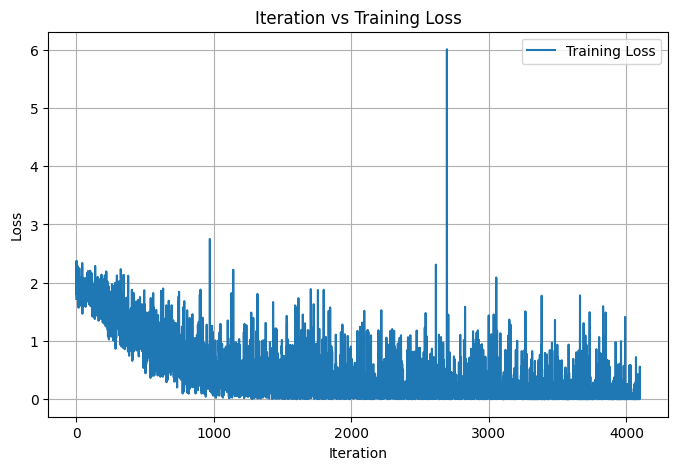

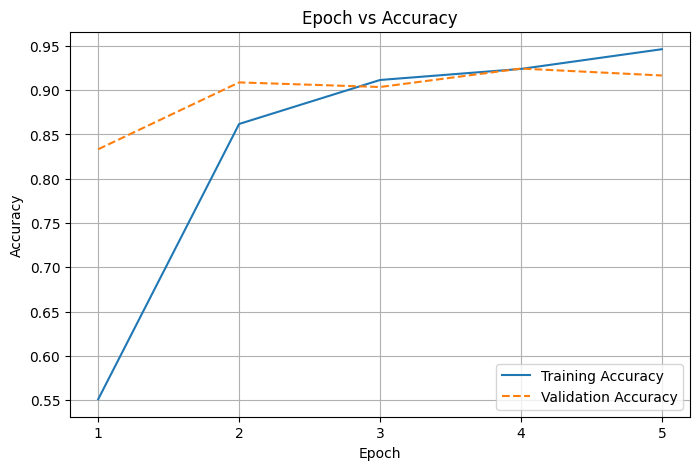

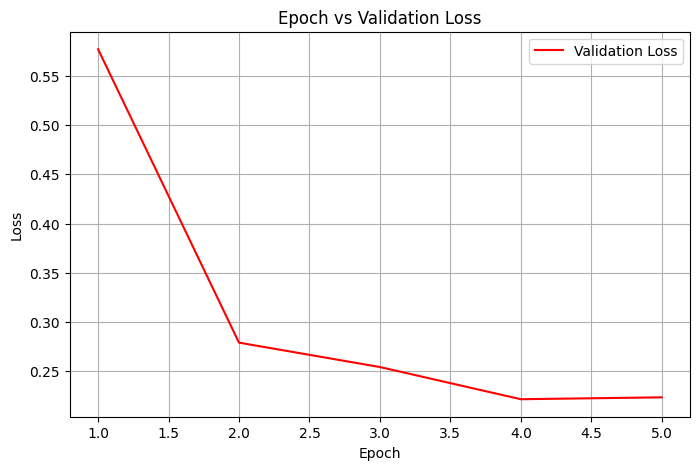

In [89]:
# Plot Iteration vs Training Loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X_1 = np.arange(len(train_accuracies)) + 1
plt.figure(figsize=(8, 5))
plt.plot(acc_X_1, train_accuracies, label="Training Accuracy")
plt.plot(acc_X_1, val_accuracies, label="Validation Accuracy", linestyle="--")
plt.xticks(acc_X_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot Epoch vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

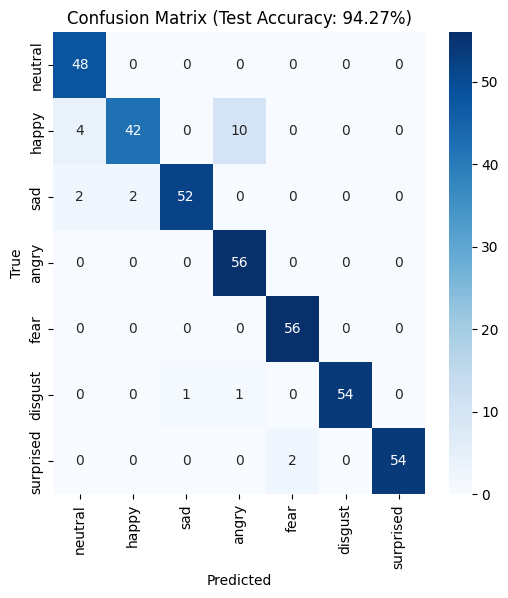


Classification Report:

              precision    recall  f1-score   support

     neutral       0.89      1.00      0.94        48
       happy       0.95      0.75      0.84        56
         sad       0.98      0.93      0.95        56
       angry       0.84      1.00      0.91        56
        fear       0.97      1.00      0.98        56
     disgust       1.00      0.96      0.98        56
   surprised       1.00      0.96      0.98        56

    accuracy                           0.94       384
   macro avg       0.95      0.94      0.94       384
weighted avg       0.95      0.94      0.94       384



In [90]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
labels_names = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprised"]

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Test Accuracy: {test_accuracy*100:.2f}%)")
plt.show()

# Compute Precision, Recall, F1-Score
print("\nClassification Report:\n")
print(classification_report(all_labels, all_predictions, target_names=labels_names))

In [ ]:
# Create a pandas DataFrame for analysis
df_results = pd.DataFrame({
    "Real": all_labels,
    "Predicted": all_predictions
})

# Example if you need to map class numbers to names:
# label_map = {0: "Happy", 1: "Sad"}
# df_results["Real"] = df_results["Real"].map(label_map)
# df_results["Predicted"] = df_results["Predicted"].map(label_map)

df_results.head()

,Real,Predicted
0,4,4
1,7,7
2,5,5
3,3,3
4,2,2


##### Results analysis final:

In [116]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [118]:
model.load_state_dict(torch.load("ravdess-tess-hubert-model-best.pth"))
model.eval()
test_correct = 0
test_count = 0

all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    input_ids = batch["input_values"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["emotion_label"].to(device)

    logits = model(input_ids, attention_mask=attention_mask).logits
    predictions = predict(logits)

    test_correct += predictions.eq(labels).sum().item()
    test_count += len(labels)

    # Store for later metrics
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predictions.cpu().numpy())

test_accuracy = test_correct / test_count
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Accuracy: 0.964


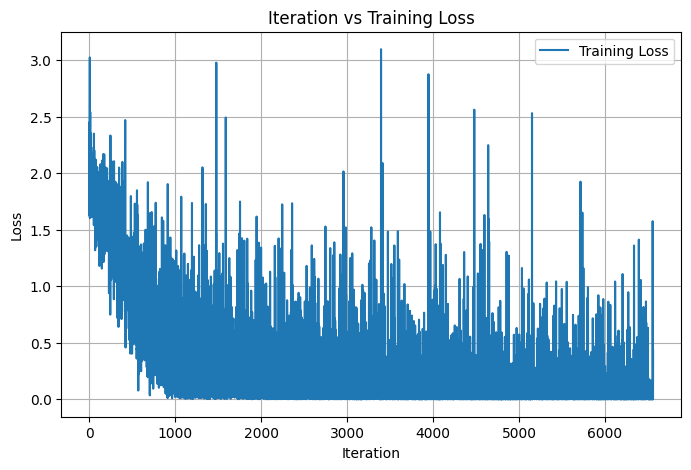

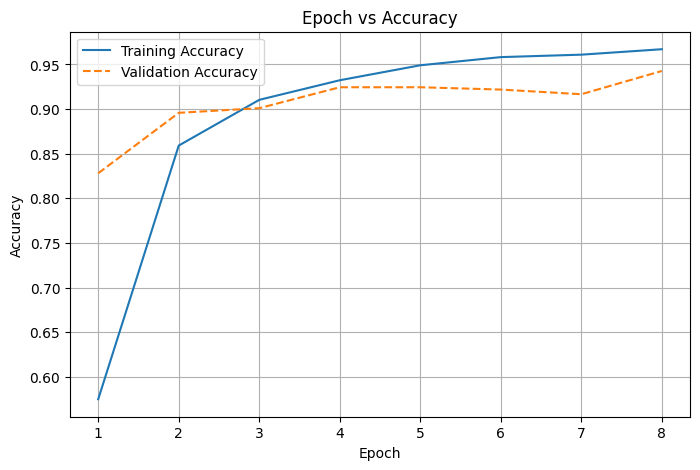

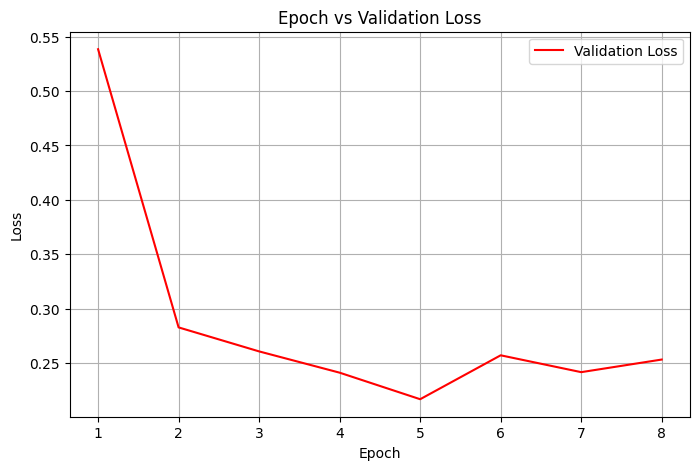

In [119]:
# Plot Iteration vs Training Loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X_1 = np.arange(len(train_accuracies)) + 1
plt.figure(figsize=(8, 5))
plt.plot(acc_X_1, train_accuracies, label="Training Accuracy")
plt.plot(acc_X_1, val_accuracies, label="Validation Accuracy", linestyle="--")
plt.xticks(acc_X_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot Epoch vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

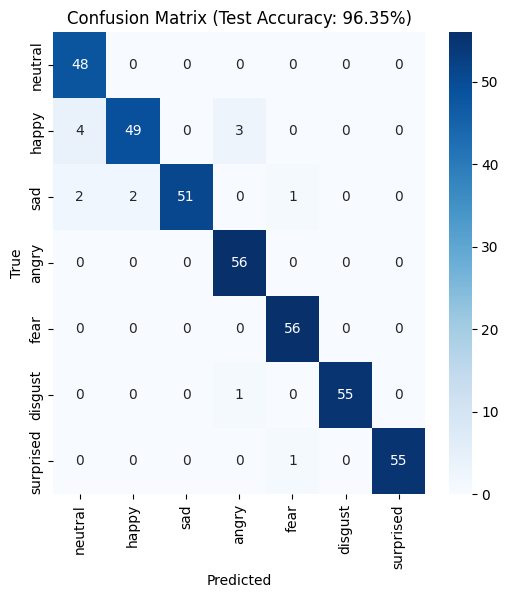


Classification Report:

              precision    recall  f1-score   support

     neutral       0.89      1.00      0.94        48
       happy       0.96      0.88      0.92        56
         sad       1.00      0.91      0.95        56
       angry       0.93      1.00      0.97        56
        fear       0.97      1.00      0.98        56
     disgust       1.00      0.98      0.99        56
   surprised       1.00      0.98      0.99        56

    accuracy                           0.96       384
   macro avg       0.96      0.96      0.96       384
weighted avg       0.97      0.96      0.96       384



In [120]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
labels_names = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprised"]

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Test Accuracy: {test_accuracy*100:.2f}%)")
plt.show()

# Compute Precision, Recall, F1-Score
print("\nClassification Report:\n")
print(classification_report(all_labels, all_predictions, target_names=labels_names))

In [121]:
# Create a pandas DataFrame for analysis
df_results = pd.DataFrame({
    "Real": all_labels,
    "Predicted": all_predictions
})

# Example if you need to map class numbers to names:
# label_map = {0: "Happy", 1: "Sad"}
# df_results["Real"] = df_results["Real"].map(label_map)
# df_results["Predicted"] = df_results["Predicted"].map(label_map)

df_results.head()

,Real,Predicted
0,6,6
1,5,5
2,0,0
3,4,4
4,3,3


#### Calm + neutral emotions training:

In [ ]:
# Combine calm (1) into neutral (0)
train_df['emotion_label'] = train_df['emotion_label'].replace(1, 0)
val_df['emotion_label'] = val_df['emotion_label'].replace(1, 0)
test_df['emotion_label'] = test_df['emotion_label'].replace(1, 0)

train_df['emotion_label'] = train_df['emotion_label'].apply(lambda x: x if x == 0 else x - 1)
val_df['emotion_label'] = val_df['emotion_label'].apply(lambda x: x if x == 0 else x - 1)
test_df['emotion_label'] = test_df['emotion_label'].apply(lambda x: x if x == 0 else x - 1)

print("Train label counts:\n", train_df['emotion_label'].value_counts().sort_index())
print("Validation label counts:\n", val_df['emotion_label'].value_counts().sort_index())
print("Test label counts:\n", test_df['emotion_label'].value_counts().sort_index())

Train label counts:
 emotion_label
0    632
1    552
2    552
3    552
4    552
5    552
6    552
Name: count, dtype: int64
Validation label counts:
 emotion_label
0    28
1    20
2    20
3    20
4    20
5    20
6    20
Name: count, dtype: int64
Test label counts:
 emotion_label
0    28
1    20
2    20
3    20
4    20
5    20
6    20
Name: count, dtype: int64


##### Model setup & training:

In [ ]:
import librosa
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import Wav2Vec2FeatureExtractor

In [ ]:
def map_to_array(example):
  speech, _ = librosa.load(example["file_path"], sr=16000, mono=True)
  example["speech"] = speech
  return example

In [ ]:
train_data = Dataset.from_pandas(train_df).map(map_to_array)
val_data = Dataset.from_pandas(val_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

Map:   0%|          | 0/3944 [00:00<?, ? examples/s]

Map:   0%|          | 0/148 [00:00<?, ? examples/s]

Map:   0%|          | 0/148 [00:00<?, ? examples/s]

In [ ]:
del train_df, test_df, val_df
gc.collect()

16374

In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , num_labels=num_labels)

In [ ]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [ ]:
os.makedirs("./batches_1", exist_ok=True)

In [ ]:
def save_batched_encodings(data, labels, feature_extractor, batch_size, prefix, output_dir):
  os.makedirs(output_dir, exist_ok=True)
  total = len(data)

  for i in tqdm(range(0, total, batch_size), desc=f"Encoding {prefix}"):
    batch_data = data[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    encodings = feature_extractor(batch_data, sampling_rate=16000, padding=True, return_tensors="pt")
    torch.save((encodings, batch_labels), os.path.join(output_dir, f"{prefix}_batch_{i//batch_size}.pt"))

    del encodings, batch_data, batch_labels
    gc.collect()

In [ ]:
save_batched_encodings(list(train_data["speech"]), list(train_data["emotion_label"]), feature_extractor, batch_size=256, prefix="train", output_dir="./batches_1")
save_batched_encodings(list(val_data["speech"]), list(val_data["emotion_label"]), feature_extractor, batch_size=256, prefix="val", output_dir="./batches_1")
save_batched_encodings(list(test_data["speech"]), list(test_data["emotion_label"]), feature_extractor, batch_size=256, prefix="test", output_dir="./batches_1")

Encoding test: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


In [ ]:
import torch
from torch.utils.data import Dataset

class BatchedDataset(Dataset):
  def __init__(self, batch_files):
    self.batch_files = batch_files
    self.samples = []

    for batch_idx, file in enumerate(batch_files):
      encodings, labels = torch.load(file, weights_only=False)
      n = len(labels)
      self.samples.extend([(batch_idx, i) for i in range(n)])

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    batch_idx, sample_idx = self.samples[idx]
    batch_file = self.batch_files[batch_idx]

    # Load full batch — must disable weights_only
    encodings, labels = torch.load(batch_file, weights_only=False)

    item = {key: val[sample_idx] for key, val in encodings.items()}
    item["emotion_label"] = torch.tensor(labels[sample_idx])
    return item

In [ ]:
from glob import glob

train_files = sorted(glob("./batches_1/train_batch_*.pt"))
val_files = sorted(glob("./batches_1/val_batch_*.pt"))
test_files = sorted(glob("./batches_1/test_batch_*.pt"))

train_dataset = BatchedDataset(train_files)
val_dataset = BatchedDataset(val_files)
test_dataset = BatchedDataset(test_files)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_values = [item["input_values"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = torch.tensor([item["emotion_label"] for item in batch])

    input_values_padded = pad_sequence(input_values, batch_first=True)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True)

    return {
        "input_values": input_values_padded,
        "attention_mask": attention_mask_padded,
        "emotion_label": labels
    }

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [ ]:
from torch.optim import AdamW
from transformers import HubertForSequenceClassification

In [ ]:
num_labels=7
# model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er", num_labels=num_labels, ignore_mismatched_sizes=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.gradient_checkpointing_enable()
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [ ]:
def predict(outputs):
  probabilities = torch.softmax(outputs["logits"], dim=1)
  predictions = torch.argmax(probabilities, dim=1)
  return predictions

In [ ]:
def evaluate(model, val_loader):
  model.eval()
  correct = 0
  count = 0
  val_loss = 0.0
  with torch.no_grad():
    for batch in val_loader:
      input_ids = batch["input_values"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["emotion_label"].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs['loss']
      val_loss += loss.item()

      predictions = predict(outputs)
      correct += predictions.eq(labels).sum().item()
      count += len(labels)

  val_accuracy = correct / count
  val_loss = val_loss / len(val_loader)

  return val_loss, val_accuracy

In [ ]:
len(train_dataset)

3944

In [ ]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


In [ ]:
print(set(train_data["emotion_label"]))

{0, 1, 2, 3, 4, 5, 6}


In [ ]:
import torch
import time
from tqdm import tqdm
from google.colab import files

epochs = 10
train_loss, train_accuracies = [], []
val_losses, val_accuracies = [], []

model.train()

for epoch_i in range(epochs):
    print(f'\nEpoch {epoch_i + 1}/{epochs}')
    time.sleep(0.3)

    total_correct = 0
    total_samples = 0
    epoch_losses = []

    model.train()
    pbar = tqdm(train_loader, desc="Training")

    for batch in pbar:
        optim.zero_grad()

        input_ids = batch["input_values"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["emotion_label"].to(device)

        # print("Labels:", labels)
        # print("Labels dtype:", labels.dtype)
        # print("Labels min/max:", labels.min().item(), labels.max().item())

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        loss.backward()
        optim.step()

        # Accuracy
        predictions = predict(outputs)
        correct = predictions.eq(labels).sum().item()
        total_correct += correct
        total_samples += len(labels)
        accuracy = total_correct / total_samples

        epoch_losses.append(loss.item())

        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Accuracy": f"{accuracy:.4f}"
        })

    # Save model
    if epoch_i % 5 == 0:
      model_path = f"ravdess-tess-hubert-model-{epoch_i}.pth"
      torch.save(model.state_dict(), model_path)
      files.download(model_path)

    train_loss.extend(epoch_losses)
    train_accuracies.append(accuracy)

    # Validation
    val_loss, val_accuracy = evaluate(model, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


Epoch 1/10


Training: 100%|██████████| 986/986 [17:03<00:00,  1.04s/it, Loss=0.0521, Accuracy=0.5923]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation Loss: 1.0503, Accuracy: 0.6622

Epoch 2/10


Training: 100%|██████████| 986/986 [16:58<00:00,  1.03s/it, Loss=0.6830, Accuracy=0.8760]


Validation Loss: 0.9364, Accuracy: 0.7365

Epoch 3/10


Training: 100%|██████████| 986/986 [16:57<00:00,  1.03s/it, Loss=0.4821, Accuracy=0.9173]


Validation Loss: 0.8490, Accuracy: 0.7432

Epoch 4/10


Training:  84%|████████▍ | 826/986 [14:12<02:47,  1.05s/it, Loss=0.0253, Accuracy=0.9243]

In [ ]:
model_path = f"ravdess-tess-hubert-model-{epoch_i}.pth"
torch.save(model.state_dict(), model_path)
files.download(model_path)

##### Results analysis:

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
model.eval()
test_correct = 0
test_count = 0

all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    input_ids = batch["input_values"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["emotion_label"].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    predictions = predict(outputs)

    test_correct += predictions.eq(labels).sum().item()
    test_count += len(labels)

    # Store for later metrics
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predictions.cpu().numpy())

test_accuracy = test_correct / test_count
print(f"Test Accuracy: {test_accuracy:.3f}")

In [ ]:
# Plot Iteration vs Training Loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X_1 = np.arange(len(train_accuracies)) + 1
plt.figure(figsize=(8, 5))
plt.plot(acc_X_1, train_accuracies, label="Training Accuracy")
plt.plot(acc_X_1, val_accuracies, label="Validation Accuracy", linestyle="--")
plt.xticks(acc_X_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot Epoch vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
labels_names = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprised"]

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Test Accuracy: {test_accuracy*100:.2f}%)")
plt.show()

# Compute Precision, Recall, F1-Score
print("\nClassification Report:\n")
print(classification_report(all_labels, all_predictions, target_names=labels_names))

In [ ]:
# Create a pandas DataFrame for analysis
df_results = pd.DataFrame({
    "Real": all_labels,
    "Predicted": all_predictions
})

# Example if you need to map class numbers to names:
# label_map = {0: "Happy", 1: "Sad"}
# df_results["Real"] = df_results["Real"].map(label_map)
# df_results["Predicted"] = df_results["Predicted"].map(label_map)

df_results.head()